In [1]:
# data from: https://www.kaggle.com/datasets/bahadoreizadkhah/face-mask-types-dataset/code
# reference: https://github.com/ricardomcupido/Gogle-Colab-Face-Mask-Classification
# reference: https://towardsdatascience.com/from-alexnet-to-nasnet-a-brief-history-and-introduction-of-convolutional-neural-networks-cf63bf3320e1 
# reference: https://github.com/Alexiush/weak-causality-and-causal-disposition-in-images/blob/main/ca_cnn_sample_resnet.ipynb

import matplotlib.pylab as plt
import numpy as np
from numpy import interp
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, models
from itertools import cycle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pathlib

In [2]:
#Se monta la unidad de Google Drive
# drive.mount('/content/gdrive', force_remount=True)

DATA_TRAIN = '/Users/ashleycui/code/dev/deep_learning_project/src/task6/4-facemasks/Dataset/train'
DATA_TEST = '/Users/ashleycui/code/dev/deep_learning_project/src/task6/4-facemasks/Dataset/test'

#Se almacenan los datos de la carpeta Train
# data_train = "/content/gdrive/MyDrive/Codigo_Colab/conjunto-datos/Train"
data_train = pathlib.Path('./Dataset/train')

#Se almacenan los datos de la carpeta Test
# data_test = "/content/gdrive/MyDrive/Codigo_Colab/conjunto-datos/Test"
data_test = pathlib.Path('./Dataset/test')

#Se define el tamaño de entrada de las imagenes
IMAGE_SIZE=(300, 300)
#Se define el tamaño del lote de datos que se utilizara 
datagen_kwargs = dict(rescale=1./255)

In [3]:
#Se utiliza la funcion ImageDataGenerator en conjunto con el diccionario para reescalar las imagenes de prueba
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
#Definimos los operadores para la modificacion de las imagenes en ImageGnerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode= "nearest",
    **datagen_kwargs)


#Creamos el generador con los datos de prueba
test_generator = test_datagen.flow_from_directory(
    data_test, target_size=IMAGE_SIZE,  color_mode="rgb" ,batch_size=1450,
    class_mode='categorical',
    shuffle=False)

BATCH_SIZE=12 
#Generador con los datos de 
train_generator = train_datagen.flow_from_directory(
    data_train, subset="training", shuffle=True, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, color_mode="rgb",
    interpolation="bilinear", class_mode='categorical')

x_test, y_test = next(test_generator)
x_train, y_train = next(train_generator)

Found 330 images belonging to 5 classes.
Found 1956 images belonging to 5 classes.


In [4]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
#Precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
#F1
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 5*((precision*recall)/(precision+recall+K.epsilon()))
#Especificidad
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [5]:
from tensorflow.keras.layers import Lambda

resn_model = tf.keras.applications.ResNet101V2(input_shape=(300, 300,3), include_top=False, weights=None)

resn_model.trainable = True

fine_tune_at = 100
for layer in resn_model.layers[:fine_tune_at]:
    layer.trainable =  False

model = models.Sequential([# Lambda(lambda x: x, input_shape=(300, 300, 3)), 
                    tf.keras.layers.InputLayer((300, 300, 3)),
                    resn_model,
                    GlobalAveragePooling2D(),
                    Flatten(),
                    Dense(5, activation='softmax')])

model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy', specificity, precision_m, recall_m],
              )

print(model.summary())

2024-09-15 13:55:34.992980: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-15 13:55:34.993012: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-09-15 13:55:34.993024: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-09-15 13:55:34.993055: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-15 13:55:34.993097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ (None, 10, 10, 2048)   │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,636,805 (162.65 MB)

 Trainable params: 39,579,653 (150.98 MB)

 Non-trainable params: 3,057,152 (11.66 MB)

None


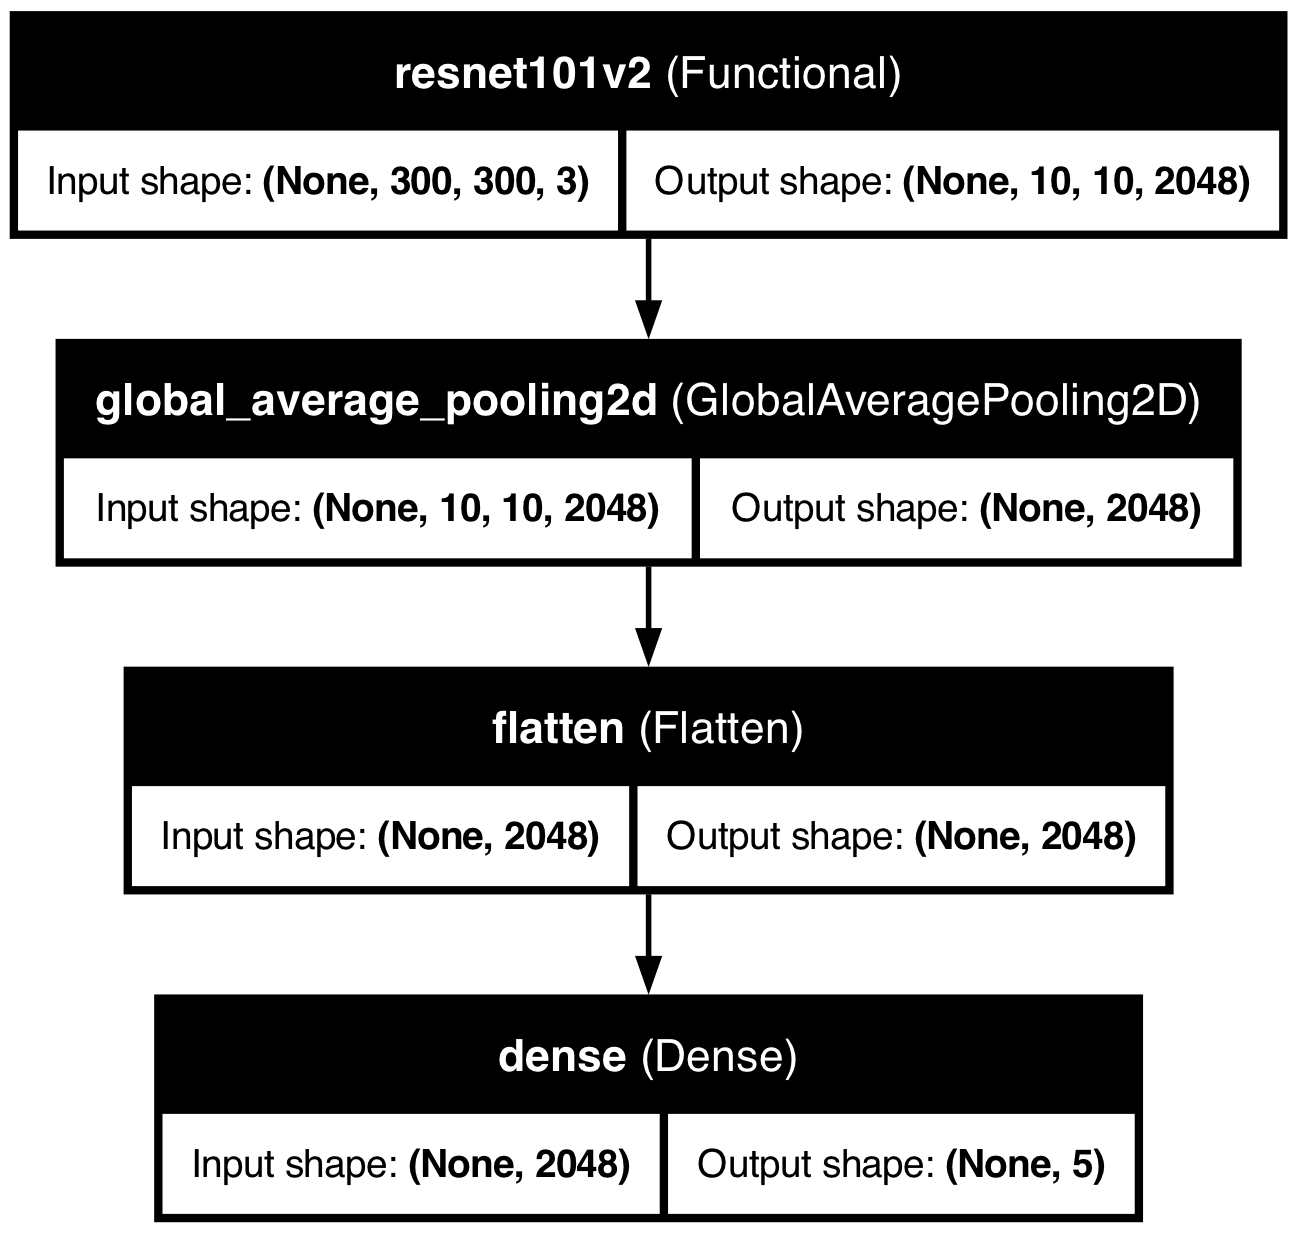

In [6]:
import tensorflow as tf
import pydot

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

/Users/ashleycui/miniconda3/envs/tf2/lib/python3.11/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


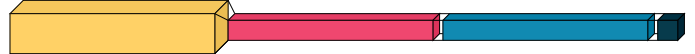

In [7]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=3, 
    # steps_per_epoch=steps_per_epoch
).history

Epoch 1/3


2024-09-15 13:55:43.303971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [ ]:
#Creacion de la matriz de confusion
y_pred=model.predict(x_test, batch_size=BATCH_SIZE)
y_pred = np.argmax(y_pred, axis=1)
cm=confusion_matrix(test_generator.classes, y_pred)

print(cm)
#Impresion de la exactitud
accu = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accu =accu.diagonal()

print(accu)
#Reporte de metricas
target_names = ['KN95', 'N95', 'Generico', 'Quirurgico', 'Sin_cubrebocas']
print(classification_report(test_generator.classes, y_pred, target_names=target_names, digits=4))

loss, accuracy, specificity, precision, recall = model.evaluate(test_generator, verbose=0)
print(loss, accuracy)

In [ ]:
plt.figure()
plt.ylabel("loss")
plt.xlabel("training steps")
plt.ylim([0,0.5])
plt.plot(hist["loss"])

plt.figure()
plt.ylabel("Accuracy (training and test)")
plt.xlabel("Training Steps")
plt.ylim([0.5,1])
plt.plot(hist["accuracy"])

plt.figure()
plt.ylabel("specification")
plt.xlabel("training steps")
plt.ylim([0.9,1])
plt.plot(hist["specificity"])

plt.figure()
plt.ylabel("sensitivity")
plt.xlabel("training steps")
plt.ylim([0.6,1])
plt.plot(hist["recall_m"])

plt.figure()
plt.ylabel("precision")
plt.xlabel("training steps")
plt.ylim([0.6,1])
plt.plot(hist["precision_m"])

In [ ]:
import matplotlib.pyplot as plt

# Impresion de la curva ROC
lw = 2
y_score = model.predict(x_test)
n_classes= 5
# Calcular la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculo de curva ROC Micropromedio y el area ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calculo la curva ROC macro-promedio y el área ROC

# Agregar las tasas de los falsos positivos
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Luego interpole todas las curvas ROC en estos puntos
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Promedio y calcule el AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficacion de las cruvas por clase
plt.figure(1)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Curva ROC de la clase {0} (area = {1:0.4f})'
                   ''.format(i, roc_auc[i]))

#Primer grafica de curvas ROC
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Sensibilidad')
plt.xlabel('1-Especificidad')
plt.legend(loc="lower right")
plt.show()

#Zoom de la primer grafica 
plt.figure(2)
plt.xlim(0, 0.08)
plt.ylim(0.9, 1)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Curva ROC de la clase {0} (area = {1:0.4f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.ylabel('Sensibilidad')
plt.xlabel('1-especificidad')

plt.legend(loc="lower right")

In [ ]:
#Obtener aquellas imagenes mal clasificadas por el modelo
def get_class_string_from_index(index):
    for class_string, class_index in test_generator.class_indices.items():
        if class_index == index:
            return class_string

count=0
print(len(x_test))
while count < 10:
    image = x_test[count,: , :, :]
    true_index = np.argmax(y_test[count])

    prediction_scores = model.predict(np.expand_dims(image, axis=0))
    predicted_index = np.argmax(prediction_scores)
    confidence= np.amax(prediction_scores)
    if true_index != predicted_index:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        print("True label: " + get_class_string_from_index(true_index))
        print("Predicted label: " + get_class_string_from_index(predicted_index))
        print("Confidence: " + str(confidence))
    count+=1

In [ ]:
model.save("./resnet101v2.h5", save_format="h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('./resnet101v2.tflite', 'wb') as f:
    f.write(tflite_model)